<a href="https://colab.research.google.com/github/dolorusso/tpe-teoria/blob/master/TPEspecial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Primero importamos las librerias que vamos a usar y configuramos numpy para mostrar 3 decimales, no usar notacion cientifica y mostrar los numeros flotantes enteros(para que cuando sean 0 se vean igual)

---



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import heapq
import requests
np.set_printoptions(precision=3, suppress=True, floatmode='fixed')
pd.set_option('display.float_format', '{:.3f}'.format)

Abrimos los archivos usando pandas

In [ ]:
oslo_dataset = pd.read_csv('https://raw.githubusercontent.com/dolorusso/tpe-teoria/refs/heads/master/datos/temperature_Oslo_celsius.csv')
quito_dataset = pd.read_csv('https://raw.githubusercontent.com/dolorusso/tpe-teoria/refs/heads/master/datos/temperature_Quito_celsius.csv')
melbourne_dataset = pd.read_csv('https://raw.githubusercontent.com/dolorusso/tpe-teoria/refs/heads/master/datos/temperature_Melbourne_celsius.csv')
melbourne_ruidoso_dataset = pd.read_csv('https://raw.githubusercontent.com/dolorusso/tpe-teoria/refs/heads/master/datos/temperature_Melbourne_celsius_ruidoso.csv')

#**Preparacion de los datos**

Función para detectar valores atípicos utilizando como criterio el rango intercuartil
Esta función recibe un dataset y devuelve los valores atípicos, Q1, Q3 e IQR en ese orden

In [ ]:
def analizar_rango_intercuartil(dataset):
    q1 = dataset['AvgTemperature'].quantile(0.25)
    q3 = dataset['AvgTemperature'].quantile(0.75)
    iqr = q3 - q1
    atipicos = dataset[(dataset['AvgTemperature'] < (q1 - 1.5 * iqr)) | (dataset['AvgTemperature'] > (q3 + 1.5 * iqr))]
    print(f"Q1: {q1}, Q3: {q3}, IQR: {iqr}")
    print(f"Valores atípicos: {atipicos['AvgTemperature'].values}")
    return atipicos

Utilizamos la función para analizar el rango intercuartil de Oslo
Al analizar lo resultados se ven valores fuera del rango intercuartil pero que no son outliers (como -21,-22,-23). Pero tambien hay valores como -73 que son imposibles por lo que decidimos eliminarlos. En realidad no solo los eliminamos... sino que reemplazamos cada valor eliminado por la media.

In [ ]:
print("Datos de Oslo:")
atipicos_oslo = analizar_rango_intercuartil(oslo_dataset)
oslo_dataset.loc[atipicos_oslo.index, 'AvgTemperature'] = int(round(oslo_dataset[oslo_dataset['AvgTemperature'] > -40]['AvgTemperature'].mean()))

Datos de Oslo:
Q1: -1.0, Q3: 12.0, IQR: 13.0
Valores atípicos: [-22.000 -21.000 -22.000 -73.000 -73.000 -73.000 -73.000 -73.000 -21.000
 -22.000 -21.000 -73.000 -73.000 -73.000 -73.000 -23.000 -22.000 -73.000
 -73.000 -73.000 -21.000 -23.000 -21.000]


Lo hacemos para Quito donde existen una gran cantidad de posibles valores atípicos en Quito, pero no son outliers por lo que no los eliminamos ya que se debe a la poca variación de la temperatura en esta ciudad. Tambien aplicamos la funcion para Melbourne donde tambien eliminamos el valor -73 al igual que en Oslo

In [ ]:
print("\nDatos de Quito:")
atipicos_quito = analizar_rango_intercuartil(quito_dataset)

print("\nDatos de Melbourne:")
atipicos_melbourne = analizar_rango_intercuartil(melbourne_dataset)
print(atipicos_melbourne.index)
media_melbourne = int(round(melbourne_dataset[melbourne_dataset['AvgTemperature'] > -40]['AvgTemperature'].mean()))
melbourne_dataset.loc[atipicos_melbourne.index, 'AvgTemperature'] = media_melbourne
melbourne_ruidoso_dataset.loc[atipicos_melbourne.index, 'AvgTemperature'] = media_melbourne


Datos de Quito:
Q1: 13.0, Q3: 14.0, IQR: 1.0
Valores atípicos: [16.000 16.000 11.000 11.000 11.000 11.000 11.000 18.000 10.000 11.000
 16.000 16.000 16.000 18.000 18.000 16.000 11.000 16.000 16.000 16.000
 11.000 11.000 10.000 11.000  9.000 16.000 11.000 11.000 11.000 11.000
 10.000 11.000 11.000 11.000 11.000 10.000 11.000 11.000 11.000 11.000
 17.000 11.000 16.000 11.000 11.000 16.000 11.000 11.000 11.000 11.000
 16.000 17.000 11.000 10.000 11.000 11.000 10.000 17.000 16.000 11.000
 11.000 17.000 11.000 11.000 11.000 11.000 10.000 11.000 16.000 11.000
 11.000 10.000 10.000 11.000 11.000 11.000 11.000 10.000 16.000 11.000
 11.000 11.000 11.000 11.000 18.000 16.000 11.000 11.000 10.000 11.000
 11.000 11.000 11.000 18.000 16.000 18.000 16.000 16.000 17.000 16.000
 16.000 17.000 16.000 16.000 16.000 16.000 16.000 16.000 16.000 11.000
 18.000 16.000 16.000 11.000 16.000 16.000 16.000 16.000 17.000 18.000
 17.000 16.000 16.000 16.000 16.000 16.000 16.000 16.000 18.000 16.000
 19.000 17.00

#**Parte 1**: Estadísticas para ingenieros que miran el cielo

##1.1 Calcular la temperatura promedio y la desviación estándar para cada señal Si y analizar cómo se comportan estadísticamente.


###Calculo...

**Media Aritmética**

Analíticamente, la media aritmética para una variable estocástica  X , que toma los valores  x1..xn  con las respectivas probabilidades  p1..pn , se calcula como **$<X> \, = ∑_{i=1}^{n} x ⋅ p(x)$**.
Dado que inicialmente no conocemos las probabilidades, nuestro método calcula la media aritmética de una manera más directa, recorriendo la fuente elemento a elemento para calcular la sumatoria de todas las temperaturas y luego dividir dicho valor por la cantidad total de datos.
Esto da como resultado la temperatura promedio en determinada ciudad a lo largo del tiempo.

**Desvío Estándar**

El desvío estándar para $X$, haciendo provecho de la implementación del método que retorna la media, se calcula como:
**$σ(X) = \sqrt{<x^2> \cdot <X>^2}$**

Creamos una funcion para hacer la media recorriendo el dataset y dividiendo la suma de los valores entre el número total de estos

In [ ]:
def calcular_media(dataset):
    suma = 0
    for valor in dataset['AvgTemperature']:
        suma += valor
    return suma / len(dataset['AvgTemperature'])

Creamos una funcion para hacer el desvio estandar recorriendo el dataset y calculando la raiz cuadrada de la varianza

In [ ]:
def calcular_desvio_estandar(dataset,media):
    suma_cuadrados = 0
    for valor in dataset['AvgTemperature']:
        suma_cuadrados += (valor - media) ** 2
    return (suma_cuadrados / len(dataset['AvgTemperature'])) ** 0.5

Creamos un diccionario con la media de la temperatura y el desvio estandar de cada ciudad para que sea mas visible

In [ ]:
# Calculamos y juntamos los resultados para guardarlos en un dataframe
media_desvio_ciudades = {
    'Ciudad': ['Oslo', 'Quito', 'Melbourne'],
    'Media': [
        calcular_media(oslo_dataset),
        calcular_media(quito_dataset),
        calcular_media(melbourne_dataset)
    ]
}
media_desvio_ciudades['Desvio_Estandar'] = [
    calcular_desvio_estandar(oslo_dataset, media_desvio_ciudades['Media'][0]),
    calcular_desvio_estandar(quito_dataset, media_desvio_ciudades['Media'][1]),
    calcular_desvio_estandar(melbourne_dataset, media_desvio_ciudades['Media'][2])
]
media_desvio_df = pd.DataFrame(media_desvio_ciudades)
# Establecemos la columna 'Ciudad' como índice de la tabla, para que las filas no sean indices numericos
media_desvio_df.set_index('Ciudad', inplace=True)
print(media_desvio_df)

           Media  Desvio_Estandar
Ciudad                           
Oslo       4.822            8.706
Quito     13.604            1.302
Melbourne 17.799            4.247


###Representacion visual

Para complementar estos datos, los analizaremos junto a la distribución de las temperaturas de cada ciudad.
Realizamos el histograma de las temperaturas de cada ciudad para observar la distribución de los datos.

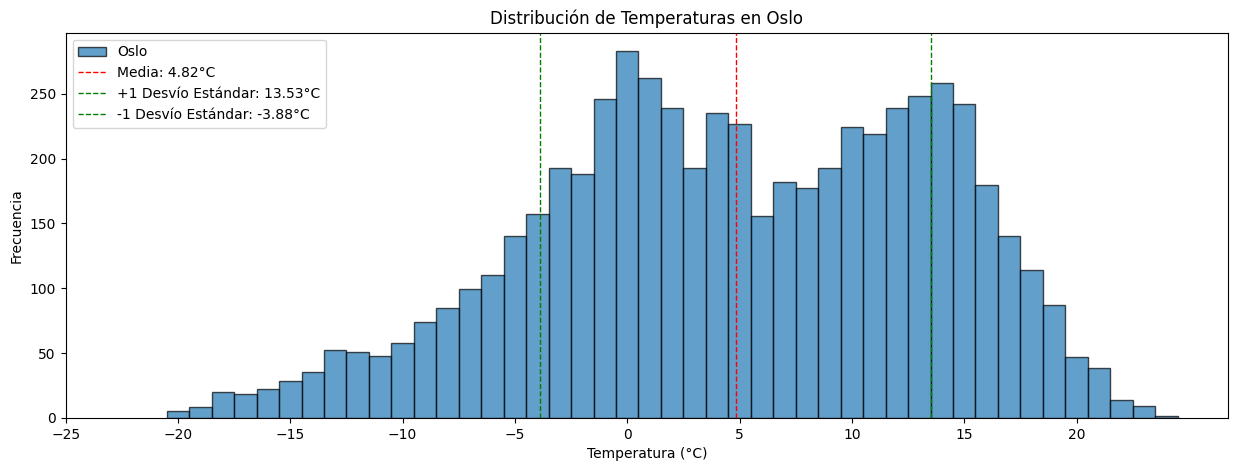

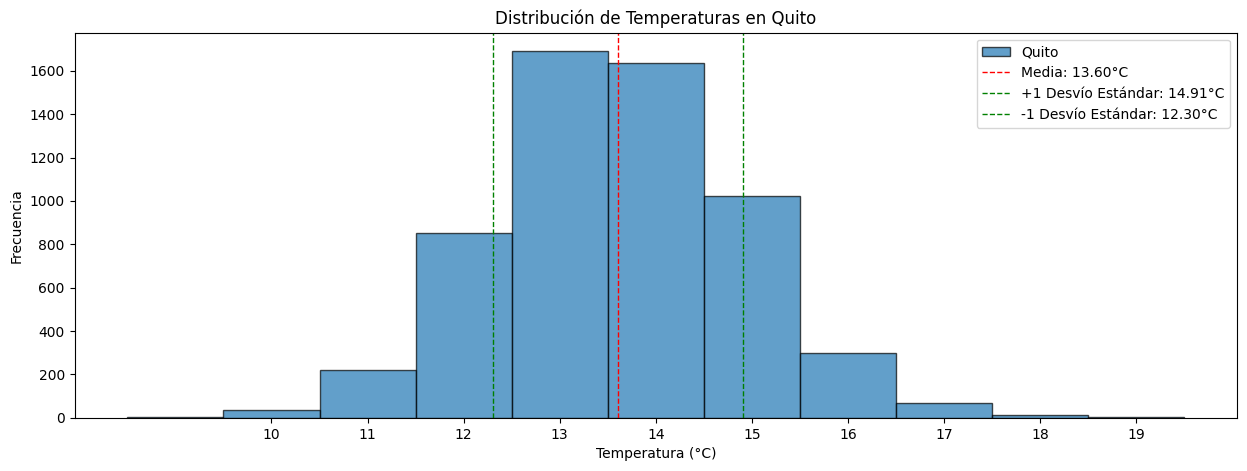

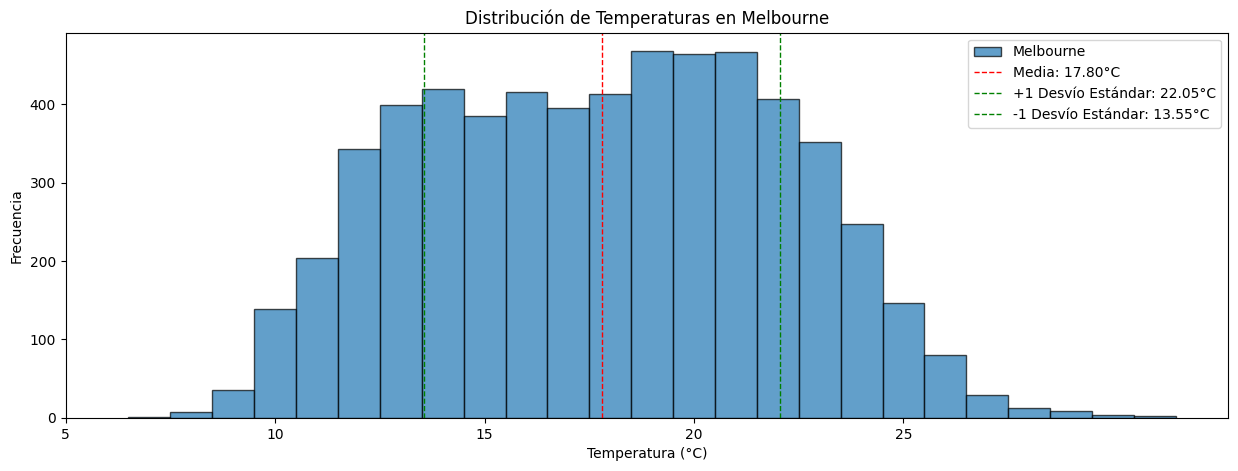

In [ ]:
def crear_histograma(dataset, ciudad,rangox):
    plt.figure(figsize=(15, 5))
    valores_unicos = sorted(dataset['AvgTemperature'].unique())
    bins = [v - 0.5 for v in range(int(min(valores_unicos)), int(max(valores_unicos)) + 2)]
    plt.hist(dataset['AvgTemperature'], bins=bins, alpha=0.7, label=ciudad, edgecolor='black')
    plt.title(f'Distribución de Temperaturas en {ciudad}')
    plt.xlabel('Temperatura (°C)')
    plt.ylabel('Frecuencia')
    #Agregamos la media y el desvío estándar al gráfico
    media = media_desvio_df.loc[ciudad]['Media']
    desvio_estandar = media_desvio_df.loc[ciudad]['Desvio_Estandar']
    plt.axvline(media, color='red', linestyle='dashed', linewidth=1, label=f'Media: {media:.2f}°C')
    plt.axvline(media + desvio_estandar, color='green', linestyle='dashed', linewidth=1, label=f'+1 Desvío Estándar: {media + desvio_estandar:.2f}°C')
    plt.axvline(media - desvio_estandar, color='green', linestyle='dashed', linewidth=1, label=f'-1 Desvío Estándar: {media - desvio_estandar:.2f}°C')
    plt.xticks(rangox)

    plt.legend()
    plt.show()

# Creamos los histogramas para cada ciudad
crear_histograma(oslo_dataset, 'Oslo',range(-25,25,5))
crear_histograma(quito_dataset, 'Quito',range(10,20,1))
crear_histograma(melbourne_dataset, 'Melbourne',range(5,30,5))

##1.2 Calcular el factor de correlación cruzada entre cada par de señales. Discutir si existen correlaciones significativas o no

El factor de correlación cruzada lo calculamos de manera tradicional aprovechando los cálculos previos de media y desvío.
La fórmula empleada es: $\sum_{i=1}^{n}\, \frac {(X_i-<X>) \,\cdot\, (Y_i\,-<Y>)}{σ(X)\cdot σ(Y)}$

In [ ]:
def calcular_correlacion_cruzada(dataset1, dataset2,nombre_ciudad1, nombre_ciudad2):
    if len(dataset1) != len(dataset2):
        raise ValueError("Los datasets deben tener la misma longitud")

    media1 = media_desvio_df.loc[nombre_ciudad1]['Media']
    media2 = media_desvio_df.loc[nombre_ciudad2]['Media']

    numerador = sum((dataset1['AvgTemperature'][i] - media1) * (dataset2['AvgTemperature'][i] - media2) for i in range(len(dataset1)))
    denominador = (sum((dataset1['AvgTemperature'][i] - media1) ** 2 for i in range(len(dataset1))) *
                   sum((dataset2['AvgTemperature'][i] - media2) ** 2 for i in range(len(dataset2)))) ** 0.5

    if denominador == 0:
        return 0

    return numerador / denominador

print("\nCorrelación cruzada entre Oslo y Quito:", calcular_correlacion_cruzada(oslo_dataset, quito_dataset, 'Oslo', 'Quito'))
print("Correlación cruzada entre Oslo y Melbourne:", calcular_correlacion_cruzada(oslo_dataset, melbourne_dataset, 'Oslo', 'Melbourne'))
print("Correlación cruzada entre Quito y Melbourne:", calcular_correlacion_cruzada(quito_dataset, melbourne_dataset, 'Quito', 'Melbourne'))


Correlación cruzada entre Oslo y Quito: 0.0836444112584467
Correlación cruzada entre Oslo y Melbourne: -0.7283730152105079
Correlación cruzada entre Quito y Melbourne: -0.025710771503313464


Creamos graficos de dispersion para comparar las temperaturas de las distintas ciudades

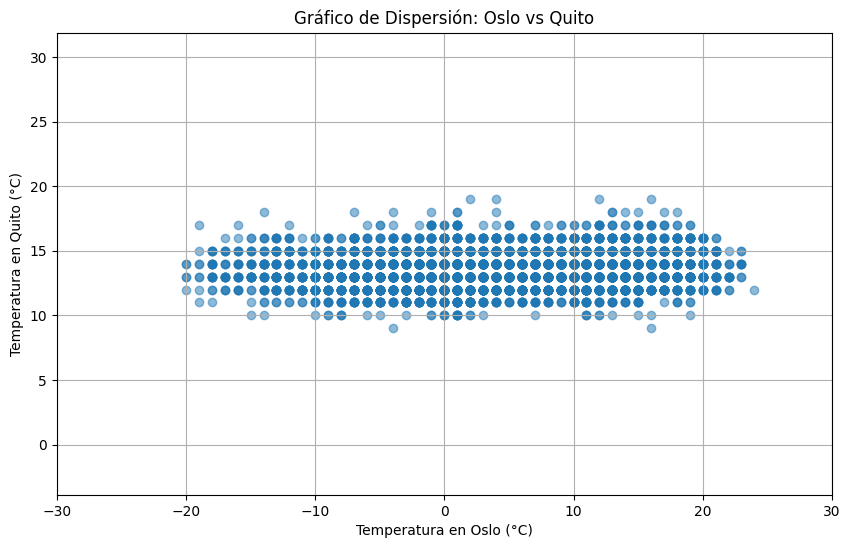

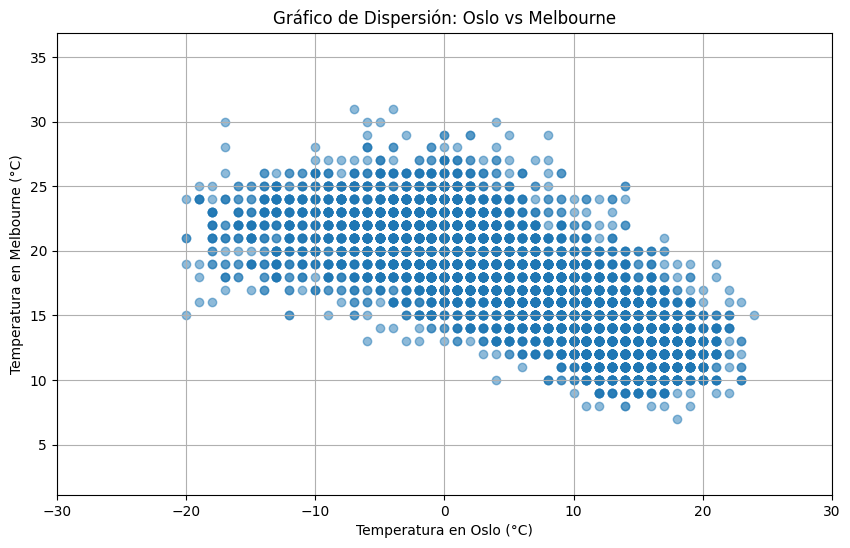

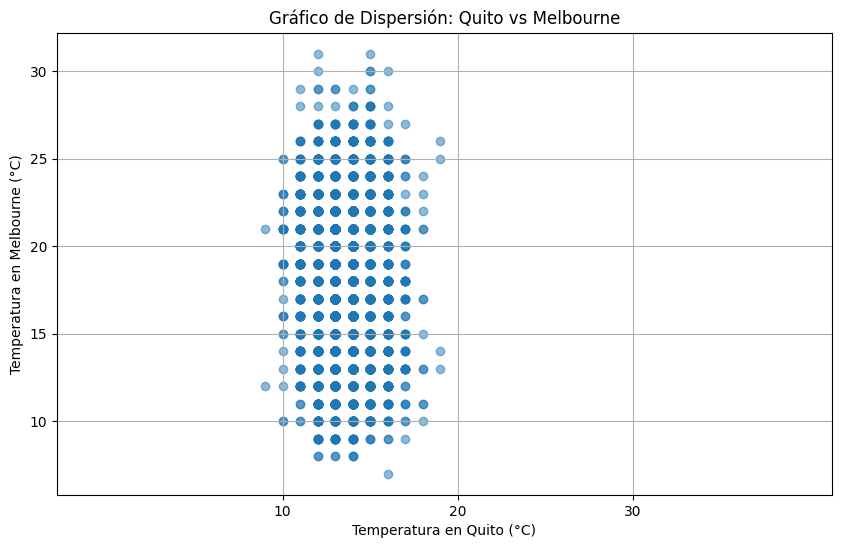

In [ ]:
def crear_grafico_dispersion(dataset1, dataset2, nombre_ciudad1, nombre_ciudad2, rangox=(-30, 30)):
    plt.figure(figsize=(10, 6))
    plt.scatter(dataset1['AvgTemperature'], dataset2['AvgTemperature'], alpha=0.5)
    plt.title(f'Gráfico de Dispersión: {nombre_ciudad1} vs {nombre_ciudad2}')
    plt.xlabel(f'Temperatura en {nombre_ciudad1} (°C)')
    plt.ylabel(f'Temperatura en {nombre_ciudad2} (°C)')
    plt.grid(True)
    plt.axis('equal')
    plt.xticks(ticks=range(rangox[0], rangox[1]+1, 10))
    plt.show()

crear_grafico_dispersion(oslo_dataset, quito_dataset, 'Oslo', 'Quito')
crear_grafico_dispersion(oslo_dataset, melbourne_dataset, 'Oslo', 'Melbourne')
crear_grafico_dispersion(quito_dataset, melbourne_dataset, 'Quito', 'Melbourne', rangox=(10, 30))

#**Parte 2**: Una fuente de calor… markoviana

Considerando los valores de temperatura t que componen cada señal Si, construir una nueva señal Ti  compuesta por una secuencia de símbolos discretos F, T o C, definidos según
- F (frío): si t < 11°C
- T (templado): si 11 ≤ t < 19°C
- C (cálido): si t ≥ 19°C

Para cada Ti:

##2.1.Modelar la fuente con memoria de orden 1 (Markov), obtener la matriz de transición

**Discretizacion de datasets**

In [ ]:
#Definimos la función de discretización
funcion_disc = lambda t: 'F' if t < 11 else 'T' if t < 19 else 'C'

#Aplicar la función de discretización a la columna 'AvgTemperature' de cada dataset, creando una nueva columna 'clima'
oslo_dataset['clima'] = oslo_dataset['AvgTemperature'].apply(funcion_disc)
quito_dataset['clima'] = quito_dataset['AvgTemperature'].apply(funcion_disc)
melbourne_dataset['clima'] = melbourne_dataset['AvgTemperature'].apply(funcion_disc)

**Calculo matriz de transición**

In [ ]:
# Función para calcular la probabilidad de transición
def calcular_matriz_transicion(entrada,salida):
    matriz_transicion = pd.DataFrame(0, index=['Fy', 'Ty', 'Cy'], columns=['Fx', 'Tx', 'Cx'])
    probabilidadMarginal = {'Fx': 0, 'Tx': 0, 'Cx': 0}
    # Recorremos la entrada y salida y vamos contando las transiciones
    for i in range(len(entrada) - 1):
        estado_actual = entrada[i] + 'x'
        estado_siguiente = salida[i] + 'y'
        probabilidadMarginal[estado_actual] += 1
        matriz_transicion.loc[estado_siguiente, estado_actual] += 1
    # Normalizamos la matriz de transición dividiendo cada columna por la probabilidad marginal de esa columna
    for estado,valor in probabilidadMarginal.items():
            matriz_transicion[estado] /= valor

    return matriz_transicion


# Calculamos la matriz de transicion para cada dataset
matriz_transicion_oslo = calcular_matriz_transicion(oslo_dataset['clima'], oslo_dataset['clima'].iloc[1:].reset_index(drop=True))
matriz_transicion_quito = calcular_matriz_transicion(quito_dataset['clima'], quito_dataset['clima'].iloc[1:].reset_index(drop=True))
matriz_transicion_melbourne = calcular_matriz_transicion(melbourne_dataset['clima'], melbourne_dataset['clima'].iloc[1:].reset_index(drop=True))

# Imprimimos las matrices de transicion
print("Matriz de transición de Oslo:\n", matriz_transicion_oslo)
print("Matriz de transición de Quito:\n", matriz_transicion_quito)
print("Matriz de transición de Melbourne:\n", matriz_transicion_melbourne)

Matriz de transición de Oslo:
       Fx    Tx    Cx
Fy 0.959 0.099 0.000
Ty 0.041 0.865 0.296
Cy 0.000 0.035 0.704
Matriz de transición de Quito:
       Fx    Tx    Cx
Fy 0.054 0.006 0.000
Ty 0.946 0.993 1.000
Cy 0.000 0.001 0.000
Matriz de transición de Melbourne:
       Fx    Tx    Cx
Fy 0.486 0.032 0.000
Ty 0.514 0.836 0.147
Cy 0.000 0.132 0.853


##2.2. Usar muestreo Monte Carlo para obtener, para cada símbolo:


###- La probabilidad estacionaria.
A partir de las matrices de transicion, calcularemos el vector estacionario con motor de monte carlo.

Primero calculamos las acumuladas

In [ ]:
# Definimos una funcion que calcula la matriz acumulada de cada fuente
def calcular_matriz_acumulada(matriz_transicion):
    matriz_np = matriz_transicion.values

    # Crear matriz resultado copiando la matriz original
    matriz_resultado = matriz_np.copy()
    # Recorrer la matriz lugar por lugar para calcular la suma acumulativa
    filas, columnas = matriz_resultado.shape
    for i in range(1, filas):  # Empezamos desde la segunda fila
        for j in range(columnas):
            matriz_resultado[i, j] = matriz_resultado[i-1, j] + matriz_resultado[i, j]
    return matriz_resultado

# Definimos la matriz acumulada de cada fuente
matriz_acumulada_oslo = calcular_matriz_acumulada(matriz_transicion_oslo)
matriz_acumulada_quito = calcular_matriz_acumulada(matriz_transicion_quito)
matriz_acumulada_melbourne = calcular_matriz_acumulada(matriz_transicion_melbourne)

print("Matriz acumulada de Oslo:\n", matriz_acumulada_oslo)
print("Matriz acumulada de Quito:\n", matriz_acumulada_quito)
print("Matriz acumulada de Melbourne:\n", matriz_acumulada_melbourne)

Matriz acumulada de Oslo:
 [[0.959 0.099 0.000]
 [1.000 0.965 0.296]
 [1.000 1.000 1.000]]
Matriz acumulada de Quito:
 [[0.054 0.006 0.000]
 [1.000 0.999 1.000]
 [1.000 1.000 1.000]]
Matriz acumulada de Melbourne:
 [[0.486 0.032 0.000]
 [1.000 0.868 0.147]
 [1.000 1.000 1.000]]


Ahora si calculamos el vector definiendo las funciones auxiliares necesarias

In [ ]:
def converge_vector(vector1, vector2, e=0.00001):
    # Compara dos vectores y verifica si la diferencia es menor que el umbral epsilon
    for i in range(len(vector1)):
        if abs(vector1[i] - vector2[i]) >= e:
            return False
    return True

# Genera el próximo estado basado en la matriz acumulada y el simbolo actual
def generar_proximo_estado(matriz_acumulada, simbolo_anterior):
    n_random = np.random.rand()  # Genera un número aleatorio entre 0 y 1
    for i in range(3):
        if matriz_acumulada[i, simbolo_anterior] > n_random:
            return i
    raise ValueError("No se pudo generar el próximo estado, matriz acumulada no válida.")


def calcular_vector_estacionario(matriz_acumulada, e=0.000001, min_iter=5000):
    # Inicializar el vector estacionario
    emisiones = np.array([0, 0, 0])  # Contador de emisiones para cada estado
    Vt_actual = np.array([0, 0, 0])  # Vector de emisiones actual
    Vt_anterior = np.array([0, 0, 0])  # Vector de emisiones anterior
    cantidad_simbolos = 0  # Contador de símbolos generados
    simbolo_actual = 0  # Estado actual, no importa su valor inicial al calcular el vector estacionario

    # Util para graficar luego
    historial_vectores = []

    while not converge_vector(Vt_actual, Vt_anterior, e) or cantidad_simbolos < min_iter:
        # Generamos el proximo simbolo
        simbolo_actual = generar_proximo_estado(matriz_acumulada, simbolo_actual)
        emisiones[simbolo_actual] += 1
        cantidad_simbolos += 1

        # Actualizamos el vector de emisiones
        Vt_anterior = Vt_actual.copy()
        Vt_actual = emisiones / cantidad_simbolos

        if cantidad_simbolos % 100 == 0:
            historial_vectores.append((cantidad_simbolos, Vt_actual.copy()))
    return Vt_actual, historial_vectores

# Calculamos el vector estacionario para cada dataset
vector_estacionario_oslo,_ = calcular_vector_estacionario(matriz_acumulada_oslo)
vector_estacionario_quito,_ = calcular_vector_estacionario(matriz_acumulada_quito)
vector_estacionario_melbourne,_ = calcular_vector_estacionario(matriz_acumulada_melbourne)

# Imprimimos los vectores estacionarios
print("Vector estacionario de Oslo:\n", vector_estacionario_oslo)
print("Vector estacionario de Quito:\n", vector_estacionario_quito)
print("Vector estacionario de Melbourne:\n", vector_estacionario_melbourne)

#Comprobacion de salida
print("Comprobacion Vector estacionario de Oslo:\n", round(sum(vector_estacionario_oslo), 3))
print("Comprobacion Vector estacionario de Quito:\n", round(sum(vector_estacionario_quito), 3))
print("Comprobacion Vector estacionario de Melbourne:\n", round(sum(vector_estacionario_melbourne), 3))


Vector estacionario de Oslo:
 [0.682 0.284 0.034]
Vector estacionario de Quito:
 [0.005 0.994 0.000]
Vector estacionario de Melbourne:
 [0.031 0.507 0.461]
Comprobacion Vector estacionario de Oslo:
 1.0
Comprobacion Vector estacionario de Quito:
 1.0
Comprobacion Vector estacionario de Melbourne:
 1.0


Tambien calculamos el teorico...

In [ ]:
def calcular_vector_estacionario_teorico(matriz_transicion):
    matriz_entrada = matriz_transicion.values
    A = matriz_entrada - np.eye(matriz_entrada.shape[0])  # Restamos la matriz identidad
    A[-1, :] = 1  # Reemplazamos la última fila por unos
    b = np.zeros(matriz_entrada.shape[0])  # Vector de 0 (excepto el último elemento)
    b[-1] = 1  # El último elemento del vector b es 1
    A = np.linalg.inv(A)
    A = A * b.T

    # Pasamos a DataFrame para seguir la misma estructura que antes
    vector_estacionario = pd.Series(A[:, -1], index=['F', 'T', 'C'])
    return vector_estacionario

Graficamos como converge a partir del vector estacionario teorico

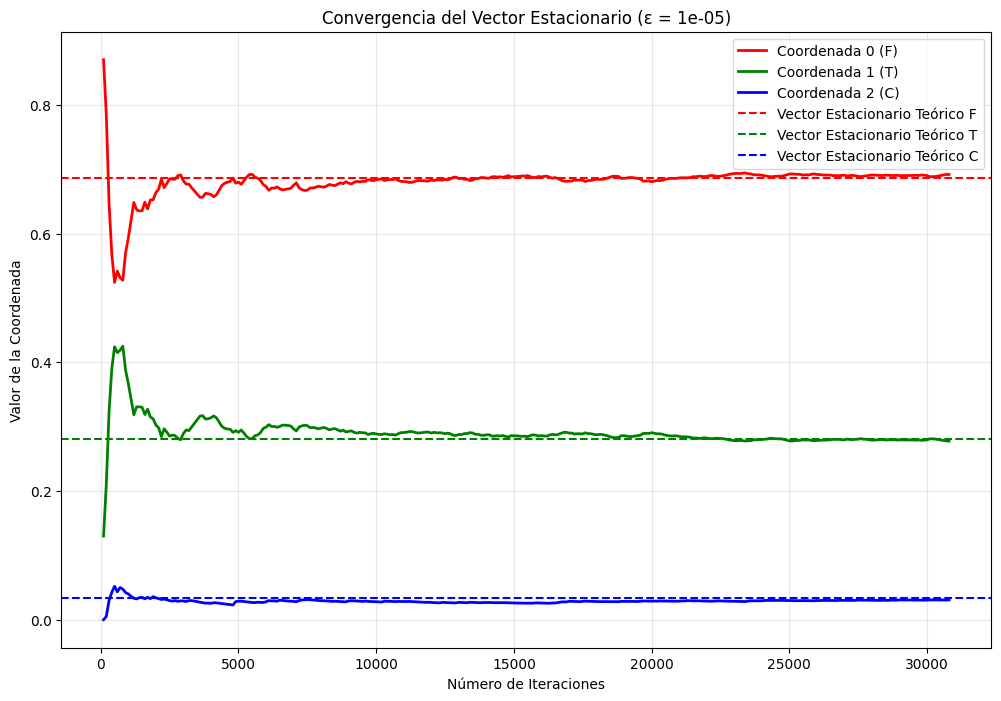

array([0.692, 0.277, 0.031])

In [ ]:
vector_estacionario_oslo_teorico = calcular_vector_estacionario_teorico(matriz_transicion_oslo)
vector_estacionario_quito_teorico = calcular_vector_estacionario_teorico(matriz_transicion_quito)
vector_estacionario_melbourne_teorico = calcular_vector_estacionario_teorico(matriz_transicion_melbourne)

def graficar_convergencia_epsilon(matriz_acumulada, estacionario_teorico, e=0.000001, min_iter=10000):
    vector_final, historial = calcular_vector_estacionario(matriz_acumulada, e, min_iter)
    # Extraer los datos del historial
    iteraciones = [punto[0] for punto in historial]
    coord_0 = [punto[1][0] for punto in historial]
    coord_1 = [punto[1][1] for punto in historial]
    coord_2 = [punto[1][2] for punto in historial]

    # Crear el gráfico
    plt.figure(figsize=(12, 8))
    plt.plot(iteraciones, coord_0, 'r-', label='Coordenada 0 (F)', linewidth=2)
    plt.plot(iteraciones, coord_1, 'g-', label='Coordenada 1 (T)', linewidth=2)
    plt.plot(iteraciones, coord_2, 'b-', label='Coordenada 2 (C)', linewidth=2)
    plt.axhline(y=estacionario_teorico.loc['F'], color='r', linestyle='--', label='Vector Estacionario Teórico F')
    plt.axhline(y=estacionario_teorico.loc['T'], color='g', linestyle='--', label='Vector Estacionario Teórico T')
    plt.axhline(y=estacionario_teorico.loc['C'], color='b', linestyle='--', label='Vector Estacionario Teórico C')

    plt.xlabel('Número de Iteraciones')
    plt.ylabel('Valor de la Coordenada')
    plt.title(f'Convergencia del Vector Estacionario (ε = {e})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return vector_final

# Comparar diferentes epsilons
graficar_convergencia_epsilon(matriz_acumulada_oslo, vector_estacionario_oslo_teorico, e=0.00001, min_iter=5000)


###- El tiempo medio de 1° recurrencia.

In [ ]:
#Definimos las funciones auxilineares necesarias
def converge(media_actual, media_anterior, e=0.00001):
    return abs(media_actual - media_anterior) < e

# Funcion para calcular el tiempo medio de primera recurrencia
def calcular_tiempo_recurrencia(matriz_acumulada, estado_inicial, e=0.0001, min_iter=5000):
    # Inicializamos las variables necesarias
    retornos = 0
    media_actual = 0
    media_anterior = 0
    cantidad_iteraciones = 0
    simbolo_actual = estado_inicial

    # Para graficar luego
    historial_convergencia = []

    while not converge(media_actual, media_anterior, e) or cantidad_iteraciones < min_iter:
        # Generamos el proximo simbolo
        simbolo_actual = generar_proximo_estado(matriz_acumulada, simbolo_actual)
        cantidad_iteraciones += 1
        if simbolo_actual == estado_inicial:
            retornos += 1
            media_anterior = media_actual
            media_actual = cantidad_iteraciones / retornos

            if retornos % 10 == 0:  # Cada 10 retornos, guardo para graficar
                historial_convergencia.append((retornos, media_actual))

    return media_actual, historial_convergencia

# Calculamos el tiempo medio de primera recurrencia para cada dataset, para cada estado y guardamos en un dataframe
def calcular_tiempos_recurrencia(matriz_acumulada, ciudad):
    estados = ['F', 'T', 'C']
    tiempos_recurrencia = {}
    for i, estado in enumerate(estados):
        tiempo, _ = calcular_tiempo_recurrencia(matriz_acumulada, i)
        tiempos_recurrencia[estado] = tiempo
    return pd.DataFrame([tiempos_recurrencia], index=[ciudad])

# Calculamos los tiempos de recurrencia para cada dataset
tiempos_recurrencia_oslo = calcular_tiempos_recurrencia(matriz_acumulada_oslo, 'Oslo')
tiempos_recurrencia_quito = calcular_tiempos_recurrencia(matriz_acumulada_quito, 'Quito')
tiempos_recurrencia_melbourne = calcular_tiempos_recurrencia(matriz_acumulada_melbourne, 'Melbourne')

#Juntamos los dataframes de tiempos de recurrencia en un frame e imprimimos el resultado
tiempos_recurrencia = pd.concat([tiempos_recurrencia_oslo, tiempos_recurrencia_quito, tiempos_recurrencia_melbourne])
print("Tiempos de recurrencia:\n", tiempos_recurrencia)

Tiempos de recurrencia:
                 F     T        C
Oslo        1.478 3.272   29.161
Quito     152.751 1.008 1510.827
Melbourne  33.912 1.978    2.185


También graficamos la convergencia de los tiempos de recurrencia

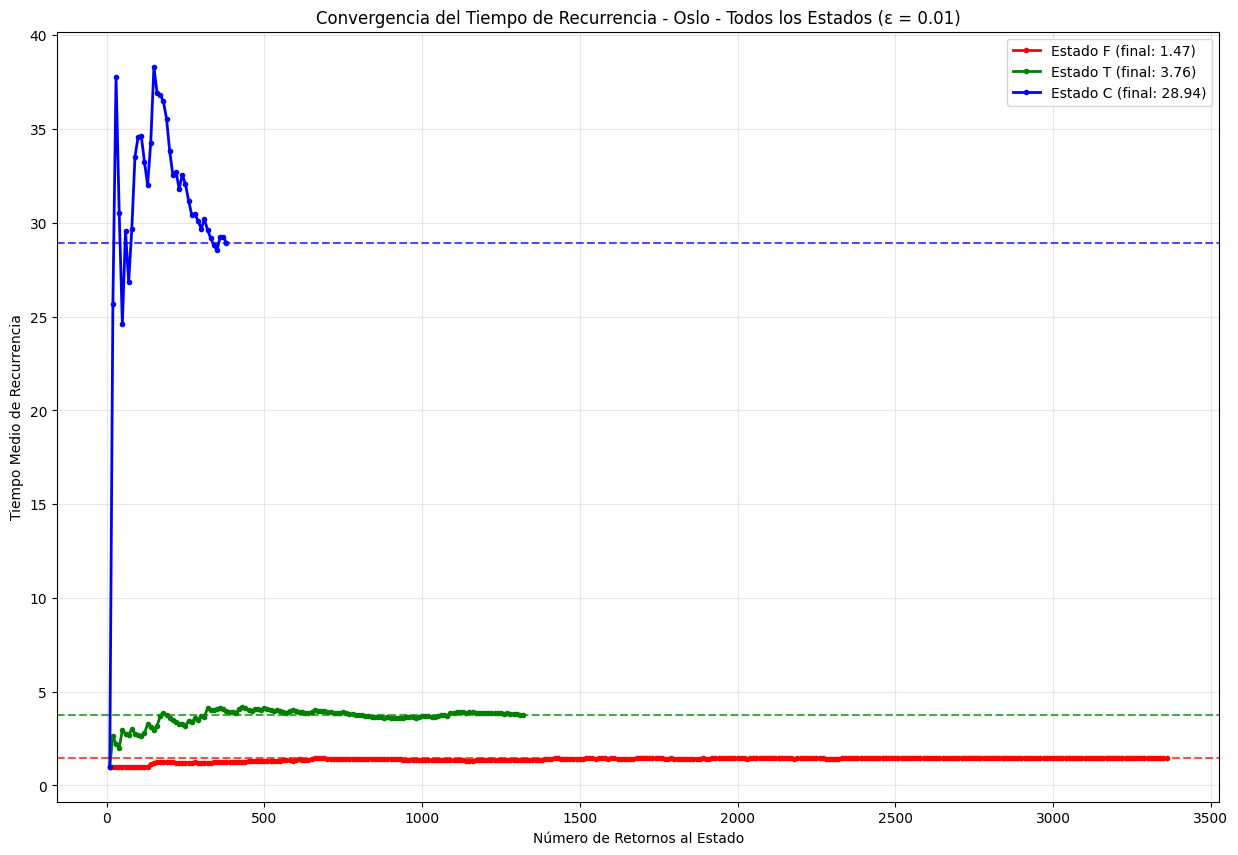

In [ ]:
# Función para graficar la convergencia de un estado específico
def graficar_convergencia_recurrencia(matriz_acumulada, estado_inicial, ciudad, estado_nombre, e=0.0001, min_iter=5000):
    tiempo_final, historial = calcular_tiempo_recurrencia(matriz_acumulada, estado_inicial, e, min_iter)

    if len(historial) == 0:
        print("No hay suficientes datos para graficar")
        return tiempo_final

    # Extraer datos del historial
    retornos = [punto[0] for punto in historial]
    medias = [punto[1] for punto in historial]

    # Crear el gráfico
    plt.figure(figsize=(12, 8))
    plt.plot(retornos, medias, 'b-', linewidth=2, marker='o', markersize=4)
    plt.axhline(y=tiempo_final, color='r', linestyle='--', alpha=0.7, label=f'Valor final: {tiempo_final:.2f}')

    plt.xlabel('Número de Retornos al Estado')
    plt.ylabel('Tiempo Medio de Recurrencia')
    plt.title(f'Convergencia del Tiempo de Recurrencia - {ciudad} - Estado {estado_nombre} (ε = {e})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return tiempo_final

# Función para comparar la convergencia de los 3 estados en un mismo gráfico
def graficar_convergencia_todos_estados(matriz_acumulada, ciudad, e=0.0001, min_iter=5000):
    estados = ['F', 'T', 'C']
    colores = ['red', 'green', 'blue']

    plt.figure(figsize=(15, 10))

    for i, (estado, color) in enumerate(zip(estados, colores)):
        tiempo_final, historial = calcular_tiempo_recurrencia(matriz_acumulada, i, e, min_iter)

        if len(historial) > 0:
            retornos = [punto[0] for punto in historial]
            medias = [punto[1] for punto in historial]

            plt.plot(retornos, medias, color=color, linewidth=2, marker='o',
                    markersize=3, label=f'Estado {estado} (final: {tiempo_final:.2f})')
            plt.axhline(y=tiempo_final, color=color, linestyle='--', alpha=0.7)

    plt.xlabel('Número de Retornos al Estado')
    plt.ylabel('Tiempo Medio de Recurrencia')
    plt.title(f'Convergencia del Tiempo de Recurrencia - {ciudad} - Todos los Estados (ε = {e})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

graficar_convergencia_todos_estados(matriz_acumulada_oslo, 'Oslo', e=0.01, min_iter=5000)


#**Parte 3**: Entropía, Huffman y la batalla por los bits

##3.1.Calcular la entropía de cada fuente Ti:

###- Sin memoria (H1), considerando símbolos individuales.
La entropia H1 se calcula como H = - $\sum_{i} p_i\, \log_2(p_i)$

Primero calculamos el vector estacionario teorico

In [ ]:
vector_estacionario_oslo = calcular_vector_estacionario_teorico(matriz_transicion_oslo)
vector_estacionario_quito = calcular_vector_estacionario_teorico(matriz_transicion_quito)
vector_estacionario_melbourne = calcular_vector_estacionario_teorico(matriz_transicion_melbourne)
print("\n\n\n")
print("Vector estacionario teorico de Oslo:\n", vector_estacionario_oslo)
print("Vector estacionario teorico de Quito:\n", vector_estacionario_quito)
print("Vector estacionario teorico de Melbourne:\n", vector_estacionario_melbourne)





Vector estacionario teorico de Oslo:
 F   0.686
T   0.281
C   0.034
dtype: float64
Vector estacionario teorico de Quito:
 F   0.006
T   0.993
C   0.001
dtype: float64
Vector estacionario teorico de Melbourne:
 F   0.031
T   0.509
C   0.460
dtype: float64


In [ ]:
def calcular_entropia_H1(vector_estacionario):
    # La entropia H1 se calcula como -sum(p * log(p)) para cada estado
    entropia = 0
    for i in vector_estacionario.index:  # Recorremos los indices del vector estacionario):
        if vector_estacionario.loc[i] > 0:  # Evitar log(0) pq da error
            entropia -= vector_estacionario.loc[i] * np.log2(vector_estacionario.loc[i])
    return entropia

H1_oslo = calcular_entropia_H1(vector_estacionario_oslo)
H1_quito = calcular_entropia_H1(vector_estacionario_quito)
H1_melbourne = calcular_entropia_H1(vector_estacionario_melbourne)

###- Con memoria (Hcondicional), usando información sobre transiciones entre símbolos.

In [ ]:
def calcular_entropia_condicional(matriz_transicion, vector_estacionario):
    entropia_condicional = 0
    for entrada in matriz_transicion.columns:  # Recorremos las columnas de la matriz de transicion
        h_i = 0
        for salida in matriz_transicion.index:  # Recorremos las filas de la matriz de transicion
            if matriz_transicion.loc[salida, entrada] > 0: # Evitar log(0) pq da error
                h_i -= matriz_transicion.loc[salida, entrada] * np.log2(matriz_transicion.loc[salida, entrada])
        entropia_condicional += vector_estacionario[entrada[0]] * h_i
    return entropia_condicional

Hcond_oslo = calcular_entropia_condicional(matriz_transicion_oslo, vector_estacionario_oslo)
Hcond_quito = calcular_entropia_condicional(matriz_transicion_quito, vector_estacionario_quito)
Hcond_melbourne = calcular_entropia_condicional(matriz_transicion_melbourne, vector_estacionario_melbourne)

Imprimimos las entropias en un dataframe conjunto

In [ ]:
entropias = pd.DataFrame({
    'H1': [H1_oslo, H1_quito, H1_melbourne],
    'Hcond': [Hcond_oslo, Hcond_quito, Hcond_melbourne]
}, index=['Oslo', 'Quito', 'Melbourne'])
print("Entropías H1 y Hcond:\n", entropias)

Entropías H1 y Hcond:
              H1  Hcond
Oslo      1.052  0.389
Quito     0.064  0.063
Melbourne 1.168  0.695


##3.2.Implementar el algoritmo de Huffman para codificar cada señal Ti  y su extensión a orden 2, teniendo en cuenta que la fuente es markoviana. Aplicar el Teorema de Shannon y analizar resultados

In [ ]:
class NodoHuffmann:
    def __init__(self, probabilidad, simbolo=None, izq=None, der=None):
        self.simbolo = simbolo
        self.probabilidad = probabilidad
        self.izq = izq
        self.der = der

    def __lt__(self, otro): #Creamos esto para comparar nodos mas facil y que se pueda utilizar en la cola de prioridad
        return self.probabilidad < otro.probabilidad


def calcular_huffman(probabilidades):
    #Creamos el minheap para almacenar los nodos y acceder de manera eficiente a los menor probabilidad
    codequeue = []
    for simbolo, probabilidad in probabilidades.items():
        if probabilidad == 0:
            continue
        nodo = NodoHuffmann(probabilidad, simbolo)
        heapq.heappush(codequeue, nodo)
    while len(codequeue) > 1:
        #Sacamos los 2 nodos con menor probabilidad
        menor_probabilidad = heapq.heappop(codequeue)
        segundo_menor_probabilidad = heapq.heappop(codequeue)
        #los combinamos en un nuevo nodo padre
        nodo_padre = NodoHuffmann(
            probabilidad=menor_probabilidad.probabilidad + segundo_menor_probabilidad.probabilidad,
            izq=menor_probabilidad,
            der=segundo_menor_probabilidad
        )
        heapq.heappush(codequeue, nodo_padre)

    # El ultimo nodo de la cola es la raíz del árbol de Huffman
    raiz = codequeue[0]
    # Generamos los códigos de Huffman
    codigos = {}
    def generar_codigos_huffman(nodo, codigo=''):
        if nodo.simbolo is not None:
            codigos[nodo.simbolo] = codigo
        else:
            generar_codigos_huffman(nodo.izq, codigo + '0')
            generar_codigos_huffman(nodo.der, codigo + '1')


    generar_codigos_huffman(raiz)
    #Pasamos el diccionario a un DataFrame
    codigos = pd.DataFrame(list(codigos.items()),columns=['Simbolo', 'Codigo'])
    codigos = codigos.set_index('Simbolo')
    return codigos

###Huffman de orden 1

In [ ]:
#llamamos a la funcion de codificacion de Huffman para cada dataset
codigos_huffman_oslo = calcular_huffman({
    'F': vector_estacionario_oslo.loc['F'],
    'T': vector_estacionario_oslo.loc['T'],
    'C': vector_estacionario_oslo.loc['C']
})
print("Códigos de Huffman para Oslo:\n", codigos_huffman_oslo)

#Calculamos para quito
codigos_huffman_quito = calcular_huffman({
    'F': vector_estacionario_quito.loc['F'],
    'T': vector_estacionario_quito.loc['T'],
    'C': vector_estacionario_quito.loc['C']
})
print("Códigos de Huffman para Quito:\n", codigos_huffman_quito)

#Calculamos para melbourne
codigos_huffman_melbourne = calcular_huffman({
    'F': vector_estacionario_melbourne.loc['F'],
    'T': vector_estacionario_melbourne.loc['T'],
    'C': vector_estacionario_melbourne.loc['C']
})
print("Códigos de Huffman para Melbourne:\n", codigos_huffman_melbourne)


Códigos de Huffman para Oslo:
         Codigo
Simbolo       
C           00
T           01
F            1
Códigos de Huffman para Quito:
         Codigo
Simbolo       
C           00
F           01
T            1
Códigos de Huffman para Melbourne:
         Codigo
Simbolo       
F           00
C           01
T            1


###Huffman de orden 2

In [ ]:
#Extendemos las fuentes a orden 2
def extender_fuente_orden_2(matriz_transicion, vector_estacionario):
    estados = ['F', 'T', 'C']
    fuente_orden_2 = {}

    for i in range(3):
        for j in range(3):
            estado = estados[i] + estados[j]
            probabilidad = matriz_transicion.loc[estados[j]+'y', estados[i]+'x'] * vector_estacionario.loc[estados[i]]
            fuente_orden_2[estado] = probabilidad
    # Guardamos en un DF para mayor legibilidad
    fuente_orden_2 = pd.DataFrame(list(fuente_orden_2.items()), columns=['Simbolo', 'Probabilidad'])
    fuente_orden_2.set_index('Simbolo', inplace=True)
    return fuente_orden_2

# Extendemos las fuentes a orden 2 para cada dataset
fuente_orden_2_oslo = extender_fuente_orden_2(matriz_transicion_oslo, vector_estacionario_oslo)
fuente_orden_2_quito = extender_fuente_orden_2(matriz_transicion_quito, vector_estacionario_quito)
fuente_orden_2_melbourne = extender_fuente_orden_2(matriz_transicion_melbourne, vector_estacionario_melbourne)

print("Fuente de orden 2 para Oslo:\n", fuente_orden_2_oslo)
print("Fuente de orden 2 para Quito:\n", fuente_orden_2_quito)
print("Fuente de orden 2 para Melboure\n:", fuente_orden_2_melbourne)

#calculamos los codigos de Huffman para las fuentes de orden 2
#primero pasamos las probabilidades de la fuente de orden 2 a un diccionario
def calcular_huffman_orden_2(fuente_orden_2):
    probabilidades = fuente_orden_2['Probabilidad'].to_dict()
    return calcular_huffman(probabilidades)

codigos_huffman_orden_2_oslo = calcular_huffman_orden_2(fuente_orden_2_oslo)
print("Códigos de Huffman de orden 2 para Oslo:\n", codigos_huffman_orden_2_oslo)

codigos_huffman_orden_2_quito = calcular_huffman_orden_2(fuente_orden_2_quito)
print("\nCódigos de Huffman de orden 2 para Quito:\n", codigos_huffman_orden_2_quito)

codigos_huffman_orden_2_melbourne = calcular_huffman_orden_2(fuente_orden_2_melbourne)
print("\nCódigos de Huffman de orden 2 para Melbourne:\n", codigos_huffman_orden_2_melbourne)


Fuente de orden 2 para Oslo:
          Probabilidad
Simbolo              
FF              0.658
FT              0.028
FC              0.000
TF              0.028
TT              0.243
TC              0.010
CF              0.000
CT              0.010
CC              0.024
Fuente de orden 2 para Quito:
          Probabilidad
Simbolo              
FF              0.000
FT              0.006
FC              0.000
TF              0.006
TT              0.986
TC              0.001
CF              0.000
CT              0.001
CC              0.000
Fuente de orden 2 para Melboure
:          Probabilidad
Simbolo              
FF              0.015
FT              0.016
FC              0.000
TF              0.016
TT              0.425
TC              0.067
CF              0.000
CT              0.067
CC              0.392
Códigos de Huffman de orden 2 para Oslo:
         Codigo
Simbolo       
TC       00000
CT       00001
CC        0001
FT        0010
TF        0011
TT          01
FF           1

C

###Teorema de Shannon y analisis
Dado el teorema de Shannon

$
\frac{H_1}{n} + \left(1 - \frac{1}{n}\right) H_{\text{cond}}
\ \leq\ \frac{l_n}{n} \ <\
\frac{H_1}{n} + \left(1 - \frac{1}{n}\right) H_{\text{cond}} + \frac{1}{n}
$

Creamos las funciones para calcular las cotas y la longitud media

In [ ]:
def calcular_limite_huffman(H1,Hcond=0,n=1):
    # H1 es la entropia de orden 1, Hcond es la entropia condicional y n es la extension de la fuente
    # Calculamos el limite inferior y superior de la longitud de los codigos de Huffman
    limite_inferior = H1/n + (1-1/n) * Hcond
    limite_superior = limite_inferior + 1/n
    return limite_inferior, limite_superior

def calcular_longitud_media(df_probabilidades, df_codigos):
    # Combinar ambos DataFrames por el índice (Simbolo)
    df_combinado = df_probabilidades.join(df_codigos)

    # Calcular la longitud de cada código
    df_combinado['Longitud'] = df_combinado['Codigo'].str.len()

    # Multiplicar probabilidad por longitud
    df_combinado['Prob_x_Long'] = df_combinado['Probabilidad'] * df_combinado['Longitud']

    # Sumar todo para obtener la longitud promedio
    longitud_promedio = df_combinado['Prob_x_Long'].sum()

    return longitud_promedio


Calculamos la long media y las cotas de Shannon para todos los datasets de orden 1

In [ ]:
# Para orden 1: convertir el vector estacionario a DataFrame
def calcular_longitud_media_orden_1(vector_estacionario, df_codigos):
    # Convertir la Serie a DataFrame con el nombre de columna correcto
    df_probabilidades = vector_estacionario.to_frame(name='Probabilidad')
    return calcular_longitud_media(df_probabilidades, df_codigos)

# Oslo
print("Limite inferior y superior de la longitud de los codigos de Huffman para Oslo orden 1:")
limite_inferior_oslo, limite_superior_oslo = calcular_limite_huffman(H1_oslo, Hcond_oslo, 1)
print(f"Limite inferior: {limite_inferior_oslo:.3f}, Limite superior: {limite_superior_oslo:.3f}")
longitud_media_oslo = calcular_longitud_media_orden_1(vector_estacionario_oslo, codigos_huffman_oslo)
print(f"Longitud media por simbolo de los codigos de Huffman para Oslo: {longitud_media_oslo:.3f}")

# Quito
print("\nLimite inferior y superior de la longitud de los codigos de Huffman para Quito orden 1:")
limite_inferior_quito, limite_superior_quito = calcular_limite_huffman(H1_quito, Hcond_quito, 1)
print(f"Limite inferior: {limite_inferior_quito:.3f}, Limite superior: {limite_superior_quito:.3f}")
longitud_media_quito = calcular_longitud_media_orden_1(vector_estacionario_quito, codigos_huffman_quito)
print(f"Longitud media por simbolo de los codigos de Huffman para Quito: {longitud_media_quito:.3f}")

# Melbourne
print("\nLimite inferior y superior de la longitud de los codigos de Huffman para Melbourne orden 1:")
limite_inferior_melbourne, limite_superior_melbourne = calcular_limite_huffman(H1_melbourne, Hcond_melbourne, 1)
print(f"Limite inferior: {limite_inferior_melbourne:.3f}, Limite superior: {limite_superior_melbourne:.3f}")
longitud_media_melbourne = calcular_longitud_media_orden_1(vector_estacionario_melbourne, codigos_huffman_melbourne)
print(f"Longitud media por simbolo de los codigos de Huffman para Melbourne: {longitud_media_melbourne:.3f}")

Limite inferior y superior de la longitud de los codigos de Huffman para Oslo orden 1:
Limite inferior: 1.052, Limite superior: 2.052
Longitud media por simbolo de los codigos de Huffman para Oslo: 1.314

Limite inferior y superior de la longitud de los codigos de Huffman para Quito orden 1:
Limite inferior: 0.064, Limite superior: 1.064
Longitud media por simbolo de los codigos de Huffman para Quito: 1.007

Limite inferior y superior de la longitud de los codigos de Huffman para Melbourne orden 1:
Limite inferior: 1.168, Limite superior: 2.168
Longitud media por simbolo de los codigos de Huffman para Melbourne: 1.491


Calculamos la long media y las cotas de Shannon para todos los datasets de orden 2

In [ ]:
#Oslo
print("limite inferior y superior de la longitud de los codigos de Huffman para Oslo orden 2:")
limite_inferior_oslo, limite_superior_oslo = calcular_limite_huffman(H1_oslo, Hcond_oslo, 2)
print(f"Limite inferior: {limite_inferior_oslo:.3f}, Limite superior: {limite_superior_oslo:.3f}")
longitud_media_oslo = calcular_longitud_media(codigos_huffman_orden_2_oslo, fuente_orden_2_oslo)
print(f"Longitud media por simbolo de los codigos de Huffman para Oslo: {longitud_media_oslo/2:.3f}")

#Quito
print("\nLimite inferior y superior de la longitud de los codigos de Huffman para Quito orden 2:")
limite_inferior_quito, limite_superior_quito = calcular_limite_huffman(H1_quito, Hcond_quito, 2)
print(f"Limite inferior: {limite_inferior_quito:.3f}, Limite superior: {limite_superior_quito:.3f}")
longitud_media_quito = calcular_longitud_media(codigos_huffman_orden_2_quito, fuente_orden_2_quito)
print(f"Longitud media por simbolo de los codigos de Huffman para Quito: {longitud_media_quito/2:.3f}")

#Melbourne
print("\nLimite inferior y superior de la longitud de los codigos de Huffman para Melbourne orden 2:")
limite_inferior_melbourne, limite_superior_melbourne = calcular_limite_huffman(H1_melbourne, Hcond_melbourne, 2)
print(f"Limite inferior: {limite_inferior_melbourne:.3f}, Limite superior: {limite_superior_melbourne:.3f}")
longitud_media_melbourne = calcular_longitud_media(codigos_huffman_orden_2_melbourne, fuente_orden_2_melbourne)
print(f"Longitud media por simbolo de los codigos de Huffman para Melbourne: {longitud_media_melbourne/2:.3f}")


limite inferior y superior de la longitud de los codigos de Huffman para Oslo orden 2:
Limite inferior: 0.721, Limite superior: 1.221
Longitud media por simbolo de los codigos de Huffman para Oslo: 0.780

Limite inferior y superior de la longitud de los codigos de Huffman para Quito orden 2:
Limite inferior: 0.063, Limite superior: 0.563
Longitud media por simbolo de los codigos de Huffman para Quito: 0.512

Limite inferior y superior de la longitud de los codigos de Huffman para Melbourne orden 2:
Limite inferior: 0.931, Limite superior: 1.431
Longitud media por simbolo de los codigos de Huffman para Melbourne: 0.975


##3.3.En cada caso, calcular la longitud total del mensaje codificado (en bits), compararla con la longitud original del archivo y obtener la tan ansiada tasa de compresión

In [ ]:
# Definimos la funcion que codifique las temperaturas de cada ciudad, dada una lista de simbolos, devuelve un string con el codigo total
def codificar_temperaturas(simbolos_sin_comprimir, codigos_huffman):
    codificacion = ''
    for simbolo in simbolos_sin_comprimir:
        codigo = codigos_huffman.loc[simbolo]['Codigo']
        codificacion += codigo
    return codificacion

def codificar_temperaturas_orden_2(simbolos_sin_comprimir, codigos_huffman):
    # Creamos una lista con los pares de simbolos no superpuestos
    dataset_pares = []
    for i in range(0,len(simbolos_sin_comprimir) - 1,2):
        # Nos aseguramos de que no haya un simbolo sobrante al final
        if i + 1 >= len(simbolos_sin_comprimir):
            break
        par = simbolos_sin_comprimir[i] + simbolos_sin_comprimir[i + 1]
        dataset_pares.append(par)

    # Codificamos las temperaturas usando la funcion ya definida
    codificacion = codificar_temperaturas(dataset_pares, codigos_huffman)
    return codificacion


Orden 1:

In [ ]:
# Codificamos las temperaturas de cada ciudad
codificacion_oslo = codificar_temperaturas(oslo_dataset['clima'].tolist(), codigos_huffman_oslo)
codificacion_quito = codificar_temperaturas(quito_dataset['clima'].tolist(), codigos_huffman_quito)
codificacion_melbourne = codificar_temperaturas(melbourne_dataset['clima'].tolist(), codigos_huffman_melbourne)

# Imprimimos las longitudes de cada codificaciones y las comparamos con el espacio que ocupara sin compresion
print("\nLongitud de la codificación de Oslo:", len(codificacion_oslo), "bits")
# Comparamos con la longitud de la codificación sin compresión, suponiendo que cada simbolo ocupa 1 byte (tamaño de char)
print("La longitud de la codificación sin compresión sería:", len(oslo_dataset) * 8, "bits")
print("Por lo tanto, la compresión es de: {:.3f}".format((len(oslo_dataset) * 8 - len(codificacion_oslo)) / (len(oslo_dataset) * 8) * 100), "%")
# Repetimos para las otras 2
print("\nLongitud de la codificación de Quito:", len(codificacion_quito), "bits")
print("La longitud de la codificación sin compresión sería:", len(quito_dataset) * 8, "bits")
print("Por lo tanto, la compresión es de: {:.3f}".format((len(quito_dataset) * 8 - len(codificacion_quito)) / (len(quito_dataset) * 8) * 100), "%")

print("\nLongitud de la codificación de Melbourne:", len(codificacion_melbourne), "bits")
print("La longitud de la codificación sin compresión sería:", len(melbourne_dataset) * 8, "bits")
print("Por lo tanto, la compresión es de: {:.3f}".format((len(melbourne_dataset) * 8 - len(codificacion_melbourne)) / (len(melbourne_dataset) * 8) * 100), "%")



Longitud de la codificación de Oslo: 7680 bits
La longitud de la codificación sin compresión sería: 46752 bits
Por lo tanto, la compresión es de: 83.573 %

Longitud de la codificación de Quito: 5885 bits
La longitud de la codificación sin compresión sería: 46752 bits
Por lo tanto, la compresión es de: 87.412 %

Longitud de la codificación de Melbourne: 8714 bits
La longitud de la codificación sin compresión sería: 46752 bits
Por lo tanto, la compresión es de: 81.361 %


Orden 2

In [ ]:
# Codificamos las temperaturas de cada ciudad
codificacion_oslo = codificar_temperaturas_orden_2(oslo_dataset['clima'].tolist(), codigos_huffman_orden_2_oslo)
codificacion_quito = codificar_temperaturas_orden_2(quito_dataset['clima'].tolist(), codigos_huffman_orden_2_quito)
codificacion_melbourne = codificar_temperaturas_orden_2(melbourne_dataset['clima'].tolist(), codigos_huffman_orden_2_melbourne)

# Oslo
# Imprimimos las longitudes de cada codificaciones y las comparamos con el espacio que ocupara sin compresion
print("\nLongitud de la codificación de Oslo:", len(codificacion_oslo), "bits")
# Comparamos con la longitud de la codificación sin compresión
print("La longitud de la codificación sin compresión sería:", len(oslo_dataset) * 8, "bits")  # 1B por simbolo, pq no estan juntos en el dataset
print("Por lo tanto, la compresión es de: {:.3f}".format((len(oslo_dataset) * 8 - len(codificacion_oslo)) / (len(oslo_dataset) * 8) * 100), "%")

#Quito
print("\nLongitud de la codificación de Quito:", len(codificacion_quito), "bits")
print("La longitud de la codificación sin compresión sería:", len(quito_dataset) * 8, "bits")
print("Por lo tanto, la compresión es de: {:.3f}".format((len(quito_dataset) * 8 - len(codificacion_quito)) / (len(quito_dataset) * 8) * 100), "%")

#Melbourne
print("\nLongitud de la codificación de Melbourne:", len(codificacion_melbourne), "bits")
print("La longitud de la codificación sin compresión sería:", len(melbourne_dataset) * 8, "bits")
print("Por lo tanto, la compresión es de: {:.3f}".format((len(melbourne_dataset) * 8 - len(codificacion_melbourne)) / (len(melbourne_dataset) * 8) * 100), "%")



Longitud de la codificación de Oslo: 4596 bits
La longitud de la codificación sin compresión sería: 46752 bits
Por lo tanto, la compresión es de: 90.169 %

Longitud de la codificación de Quito: 2998 bits
La longitud de la codificación sin compresión sería: 46752 bits
Por lo tanto, la compresión es de: 93.587 %

Longitud de la codificación de Melbourne: 5723 bits
La longitud de la codificación sin compresión sería: 46752 bits
Por lo tanto, la compresión es de: 87.759 %


#**Parte 4**: El canal climático de Musk
Ahora el satélite en órbita (SpaceHeat-42) transmite la señal S2 (de Melbourne)… pero lo que llega a la base terrestre es S4 (Melbourne “ruidoso”), misteriosamente diferente.


##4.1. Generar T4, y construir la matriz de canal comparando T2 (entrada) y T4 (salida).

In [ ]:
# Adjuntamos el clima de entrada en la tabla, para manejarlo mas facil
melbourne_ruidoso_dataset['clima_entrada'] = melbourne_dataset['clima']

# Generamos los simbolos de las temperaturas de cada ciudad (F, T, C)
melbourne_ruidoso_dataset['clima_salida'] = melbourne_ruidoso_dataset['AvgTemperature'].apply(funcion_disc)
print("\nDatos de entrada y salida de Melbourne ruidoso:\n", melbourne_ruidoso_dataset)

# Calculamos la matriz de transicion del canal T4
matriz_transicion_t4 = calcular_matriz_transicion(melbourne_ruidoso_dataset['clima_entrada'], melbourne_ruidoso_dataset['clima_salida'])
print("\nMatriz de transición del canal T4:\n", matriz_transicion_t4)


Datos de entrada y salida de Melbourne ruidoso:
       AvgTemperature clima_entrada clima_salida
0                 26             C            C
1                 14             T            T
2                 17             C            T
3                 25             C            C
4                 28             C            C
...              ...           ...          ...
5839              18             T            T
5840              18             C            T
5841              24             C            C
5842              23             C            C
5843              20             C            C

[5844 rows x 3 columns]

Matriz de transición del canal T4:
       Fx    Tx    Cx
Fy 0.574 0.139 0.000
Ty 0.426 0.677 0.243
Cy 0.000 0.185 0.757


##Calcula el Ruido del canal y la Información mutua.

Ruido...

In [ ]:
def calcular_ruido_canal(matriz_transicion,vector_estacionario): # El estacionario es F T C
    rx = {'F':0, 'T':0, 'C':0}  # Inicializamos el vector de ruido para cada estado
    for entrada in matriz_transicion.columns:
        for salida in matriz_transicion.index:
            if matriz_transicion.loc[salida, entrada] > 0:
                rx[entrada[0]] -= matriz_transicion.loc[salida, entrada] * np.log2(matriz_transicion.loc[salida, entrada])
    ruido = rx['F'] * vector_estacionario['F'] + rx['T'] * vector_estacionario['T'] + rx['C'] * vector_estacionario['C']
    return ruido

ruido_canal = calcular_ruido_canal(matriz_transicion_t4, vector_estacionario_melbourne)
print("\nRuido del canal T4:", ruido_canal)


Ruido del canal T4: 1.023140995785182


Información mutua....

In [ ]:
def calcular_informacion_mutua(matriz_transicion, vector_estacionario):
    #Primero, calculamos la distribucion de la salida
    dist_y = {'F': 0, 'T': 0, 'C': 0}
    for entrada in matriz_transicion.columns:
        for salida in matriz_transicion.index:
            dist_y[salida[0]] += matriz_transicion.loc[salida, entrada] * vector_estacionario[entrada[0]]
    # Despues calculamos la informacion mutua con el dato obtenido
    Hy = 0
    for estado in ['F', 'T', 'C']:
        if dist_y[estado] > 0:
            Hy -= dist_y[estado] * np.log2(dist_y[estado])
    return Hy - ruido_canal

informacion_mutua_canal = calcular_informacion_mutua(matriz_transicion_t4, vector_estacionario_melbourne)
print("Información mutua del canal T4:", informacion_mutua_canal)

Información mutua del canal T4: 0.3195628233815535
